In [1]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K

# plt.style.use('seaborn')
tf.__version__

'2.8.2'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
#unzip the download file
zip_ref=zipfile.ZipFile("/content/drive/MyDrive/dataset mnih/archive.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
%env SM_FRAMEWORK = tf.keras
!pip install segmentation_models
!pip install  albumentations

env: SM_FRAMEWORK=tf.keras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import segmentation_models as sm
sm.__version__

Segmentation Models: using `tf.keras` framework.


'1.0.1'

In [7]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.6
re==2.2.1
cv2==4.6.0
tensorflow==2.8.2
pandas==1.3.5
keras.api._v2.keras==2.8.0
segmentation_models==1.0.1


(1500, 1500, 3)


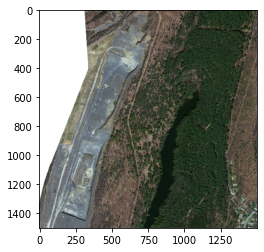

In [8]:
img = plt.imread('/content/tiff/train/10228765_15.tiff')
print(img.shape)

plt.imshow(img)

In [9]:
def build_data(PATH):
    data = []
    filenames = sorted(listdir(PATH))
    for name in filenames:
        data.append(PATH + '/' + name)
    return data

    
TRAIN_PATH = '/content/tiff/train'
LABEL_PATH = '/content/tiff/train_labels'

sat_image = build_data(TRAIN_PATH)
mask_image = build_data(LABEL_PATH)

VAL_TRAIN_PATH = '/content/tiff/val'
VAL_LABEL_PATH = '/content/tiff/val_labels'

VAL_sat_image = build_data(VAL_TRAIN_PATH)
VAL_mask_image = build_data(VAL_LABEL_PATH)






In [10]:
TEST_PATH = '/content/tiff/test'
TEST_LABEL_PATH = '/content/tiff/test_labels'

TEST_sat_image = build_data(TEST_PATH)
TEST_mask_image = build_data(TEST_LABEL_PATH)

In [11]:
len(sat_image), len(mask_image), len(VAL_sat_image), len(VAL_mask_image ),len(TEST_sat_image), len(TEST_mask_image )

(1108, 1108, 14, 14, 49, 49)

In [12]:
df = pd.DataFrame({
    'Image' : sat_image,
    'Mask' : mask_image
})

In [13]:
val_df = pd.DataFrame({
    'Val_Image' : VAL_sat_image,
    'Val_Mask' : VAL_mask_image
})

In [14]:
test_df = pd.DataFrame({
    'Test_Image' : TEST_sat_image,
    'Test_Mask' : TEST_mask_image
})

In [15]:
df

,Image,Mask
0,/content/tiff/train/10078660_15.tiff,/content/tiff/train_labels/10078660_15.tif
1,/content/tiff/train/10078675_15.tiff,/content/tiff/train_labels/10078675_15.tif
2,/content/tiff/train/10078690_15.tiff,/content/tiff/train_labels/10078690_15.tif
3,/content/tiff/train/10078705_15.tiff,/content/tiff/train_labels/10078705_15.tif
4,/content/tiff/train/10078720_15.tiff,/content/tiff/train_labels/10078720_15.tif
...,...,...
1103,/content/tiff/train/27028705_15.tiff,/content/tiff/train_labels/27028705_15.tif
1104,/content/tiff/train/27028720_15.tiff,/content/tiff/train_labels/27028720_15.tif
1105,/content/tiff/train/27178705_15.tiff,/content/tiff/train_labels/27178705_15.tif
1106,/content/tiff/train/99238660_15.tiff,/content/tiff/train_labels/99238660_15.tif


In [16]:
val_df

,Val_Image,Val_Mask
0,/content/tiff/val/10228690_15.tiff,/content/tiff/val_labels/10228690_15.tif
1,/content/tiff/val/10978735_15.tiff,/content/tiff/val_labels/10978735_15.tif
2,/content/tiff/val/10978795_15.tiff,/content/tiff/val_labels/10978795_15.tif
3,/content/tiff/val/18028945_15.tiff,/content/tiff/val_labels/18028945_15.tif
4,/content/tiff/val/21929020_15.tiff,/content/tiff/val_labels/21929020_15.tif
5,/content/tiff/val/22528900_15.tiff,/content/tiff/val_labels/22528900_15.tif
6,/content/tiff/val/22829035_15.tiff,/content/tiff/val_labels/22829035_15.tif
7,/content/tiff/val/22978990_15.tiff,/content/tiff/val_labels/22978990_15.tif
8,/content/tiff/val/23128930_15.tiff,/content/tiff/val_labels/23128930_15.tif
9,/content/tiff/val/24179245_15.tiff,/content/tiff/val_labels/24179245_15.tif


In [17]:
test_df

,Test_Image,Test_Mask
0,/content/tiff/test/10378780_15.tiff,/content/tiff/test_labels/10378780_15.tif
1,/content/tiff/test/10828720_15.tiff,/content/tiff/test_labels/10828720_15.tif
2,/content/tiff/test/11128870_15.tiff,/content/tiff/test_labels/11128870_15.tif
3,/content/tiff/test/11278840_15.tiff,/content/tiff/test_labels/11278840_15.tif
4,/content/tiff/test/11728825_15.tiff,/content/tiff/test_labels/11728825_15.tif
5,/content/tiff/test/12328750_15.tiff,/content/tiff/test_labels/12328750_15.tif
6,/content/tiff/test/15928855_15.tiff,/content/tiff/test_labels/15928855_15.tif
7,/content/tiff/test/16078870_15.tiff,/content/tiff/test_labels/16078870_15.tif
8,/content/tiff/test/17878735_15.tiff,/content/tiff/test_labels/17878735_15.tif
9,/content/tiff/test/17878780_15.tiff,/content/tiff/test_labels/17878780_15.tif


In [18]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 5, p = 0.85), 
#     A.RandomCrop(height = 512, width = 512, p = 1)
])

In [19]:
IMG_SIZE = (256, 256)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

def map_function(img, mask):
    img, mask = plt.imread(img.decode()), plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    
    img = img/255.0
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    #mask = modify_mask(mask)
    
    return img.astype(np.float64), mask.astype(np.float64)

In [20]:
BATCH_SIZE = 4

def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [21]:
IMG_SIZE = (256, 256)

def modify_mask1(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

def map_function1(img, mask):
    img, mask = plt.imread(img.decode()), plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    
    img = img/255.0
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    #mask = modify_mask(mask)
    
    return img.astype(np.float64), mask.astype(np.float64)

In [22]:
BATCH_SIZE = 4

def create_dataset1(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Val_Image'], data['Val_Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [23]:
BATCH_SIZE = 4

def create_dataset2(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Test_Image'], data['Test_Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [24]:
img.max()

255

In [25]:
train_dataset = create_dataset(df)
img, mask = next(iter(train_dataset))
img.shape, mask.shape

(TensorShape([4, 256, 256, 3]), TensorShape([4, 256, 256, 1]))

In [26]:
val_dataset = create_dataset1(val_df)
val_img, val_mask = next(iter(val_dataset))
val_img.shape, val_mask.shape

(TensorShape([4, 256, 256, 3]), TensorShape([4, 256, 256, 1]))

In [27]:
test_dataset = create_dataset2(test_df)
test_img, test_mask = next(iter(test_dataset))
test_img.shape, test_mask.shape

(TensorShape([4, 256, 256, 3]), TensorShape([4, 256, 256, 1]))

In [28]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [29]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [30]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [31]:
#IOU
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [32]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [33]:
"""
ResUNet architecture in Keras TensorFlow
"""
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class ResUnet:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        def conv_block(x, n_filter):
            x_init = x

            ## Conv 1
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)
            ## Conv 2
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (3, 3), padding="same")(x)
            ## Conv 3
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)

            ## Shortcut
            s  = Conv2D(n_filter, (1, 1), padding="same")(x_init)
            s = BatchNormalization()(s)

            ## Add
            x = Add()([x, s])
            return x

        def resnet_block(x, n_filter, pool=True):
            x1 = conv_block(x, n_filter)
            c = x1

            ## Pooling
            if pool == True:
                x = MaxPooling2D((2, 2), (2, 2))(x)
                return c, x
            else:
                return c

        n_filters = [16, 32, 64, 96, 128]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        ## Encoder
        c1, p1 = resnet_block(c0, n_filters[0])
        c2, p2 = resnet_block(p1, n_filters[1])
        c3, p3 = resnet_block(p2, n_filters[2])
        c4, p4 = resnet_block(p3, n_filters[3])

        ## Bridge
        b1 = resnet_block(p4, n_filters[4], pool=False)
        b2 = resnet_block(b1, n_filters[4], pool=False)

        ## Decoder
        d1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(b2)
        #d1 = UpSampling2D((2, 2))(b2)
        d1 = Concatenate()([d1, c4])
        d1 = resnet_block(d1, n_filters[3], pool=False)

        d2 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d1)
        #d2 = UpSampling2D((2, 2))(d1)
        d2 = Concatenate()([d2, c3])
        d2 = resnet_block(d2, n_filters[2], pool=False)

        d3 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d2)
        #d3 = UpSampling2D((2, 2))(d2)
        d3 = Concatenate()([d3, c2])
        d3 = resnet_block(d3, n_filters[1], pool=False)

        d4 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d3)
        #d4 = UpSampling2D((2, 2))(d3)
        d4 = Concatenate()([d4, c1])
        d4 = resnet_block(d4, n_filters[0], pool=False)

        ## output
        outputs = Conv2D(1, (1, 1), padding="same")(d4)
        outputs = BatchNormalization()(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [34]:
arch = ResUnet(input_size=256)
model = arch.build_model()

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 3)   0           ['max_pooling2d[0][0]']          
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 3)   0           ['max_pooling2d_1[0][0]']    

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks


In [38]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = adam,loss = dice_coef_loss,metrics=[accuracy,dice_coef, sm.metrics.iou_score,sm.metrics.recall,sm.metrics.precision,sm.metrics.f1_score,sm.metrics.f2_score])
model.summary()
filepath="/content/drive/MyDrive/Colab Notebooks/RESUNET_model_train_full.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)
callbacks_list = [checkpoint]
hist = model.fit(train_dataset, epochs= 50, batch_size= 4, validation_data= val_dataset, verbose=1,callbacks=callbacks_list)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 3)   0           ['max_pooling2d[0][0]']          
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 3)   0           ['max_pooling2d_1[0][0]']    

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        print("lr changed from {} to {}".format(lr, lr/3))
        return lr/3
    else:
        return lr
    
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [39]:
objects = {
    'accuracy'  : accuracy,
    'dice_coef' : dice_coef,
    'dice_coef_loss' : dice_coef_loss,
    'iou_score' : sm.metrics.iou_score,
    'recall'    : sm.metrics.recall,
    'precision' : sm.metrics.precision,
    'f1_score'  : sm.metrics.f1_score,
    'f2_score'  : sm.metrics.f2_score
}


In [40]:
color = [66, 255, 73]
color = [i/255.0 for i in color]

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

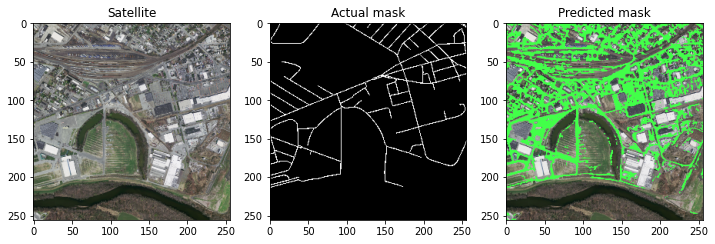

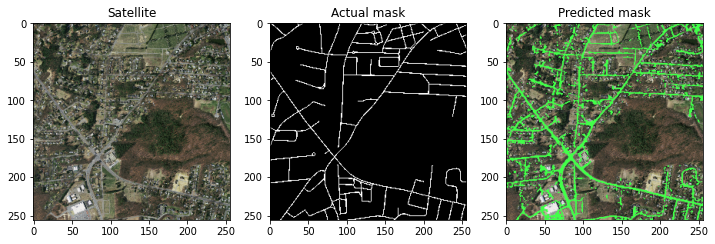

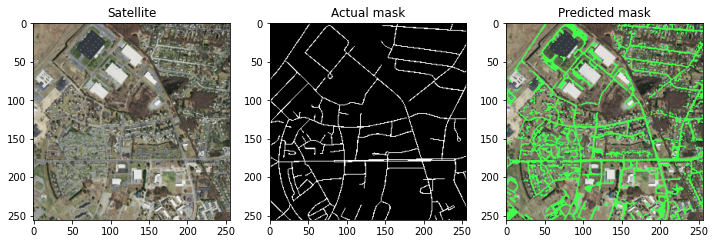

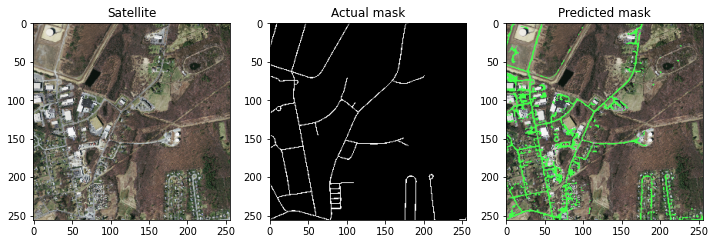

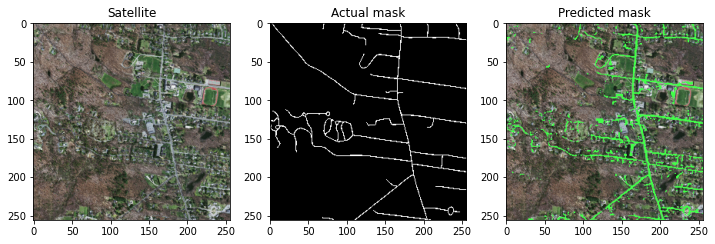

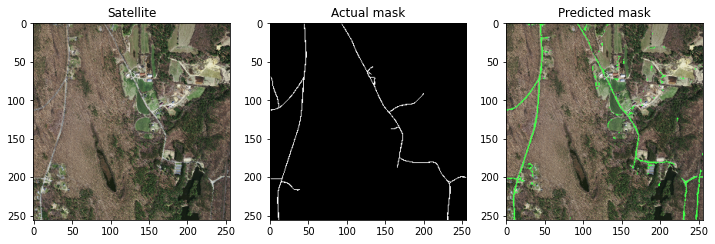

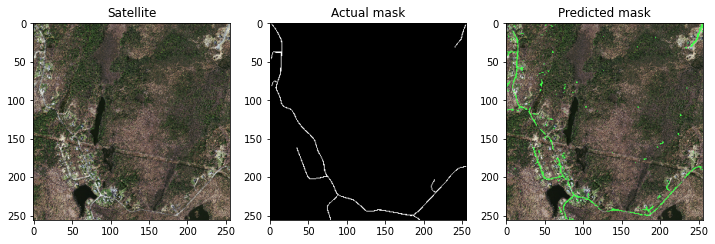

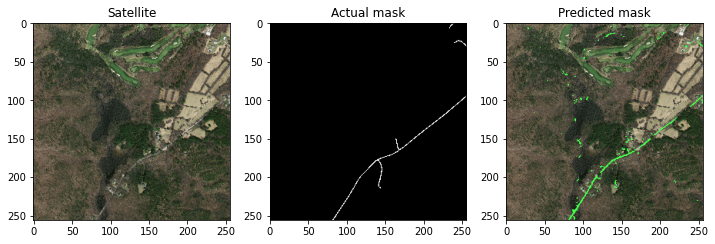

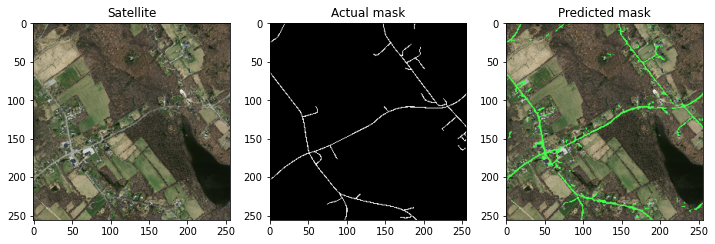

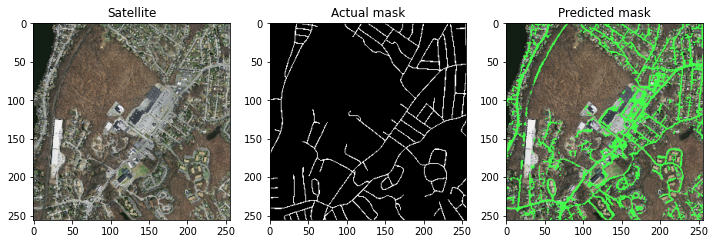

In [41]:
def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

n = 1
test_img = sorted(listdir('/content/tiff/test/'))[n:n+10]
test_mask = sorted(listdir('/content/tiff/test_labels/'))[n:n+10]

for img, mask in zip(test_img, test_mask):
    plt.figure(figsize = (12,10))
    
    img = plt.imread('/content/tiff/test/'+img)
    mask = plt.imread('/content/tiff/test_labels/'+mask)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    img = (img/255.0)
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    img = np.expand_dims(op.resize(img, (256,256)), 0)
    img = img.astype(np.float32)
    
    pred = make_pred_good(model(img))
    mask = make_pred_good(np.expand_dims(mask, axis = 0))
    
    plt.subplot(1,3,1)
    plt.title("Satellite")
    plt.imshow(img[0])
    plt.subplot(1,3,2)
    plt.title('Actual mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Predicted mask')
    pred = placeMaskOnImg(img[0], pred)
    plt.imshow(pred)
    
    plt.show()

(1068, 1163, 3)


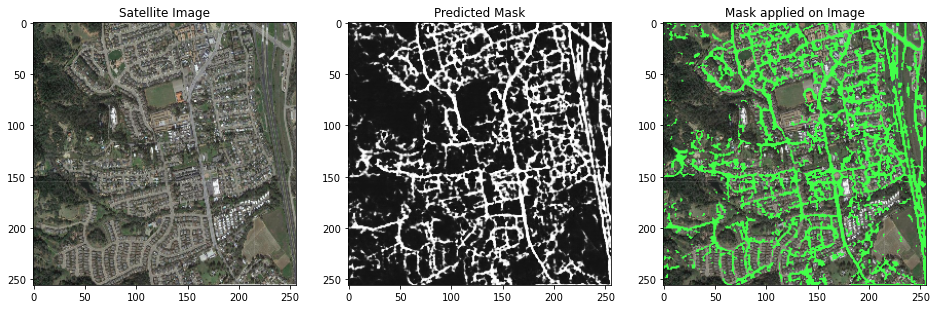

In [42]:
url = 'https://i.ibb.co/8KmHf7R/Screenshot-194.png'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]
print(img.shape)
img = img/255.0
img = op.resize(img, (256,256))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (16, 12))

plt.subplot(1, 3, 1)
plt.title("Satellite Image")
plt.imshow(img[0])

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)

plt.subplot(1,3,3)
plt.title("Mask applied on Image")
pred = placeMaskOnImg(img[0], pred)
plt.imshow(pred)
# plt.savefig('pred.jpg')

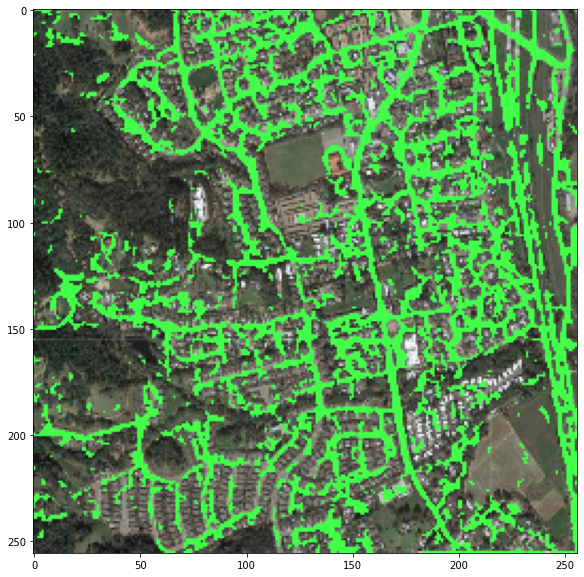

In [43]:
plt.figure(figsize = (12,10))
plt.imshow(pred)
plt.savefig('pred.jpg')

accuracy,dice_coef, sm.metrics.iou_score,sm.metrics.recall,sm.metrics.precision,sm.metrics.f1_score,sm.metrics.f2_score]

In [44]:
print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model.evaluate(train_dataset, batch_size= 4)
print('________________________')
print('Accuracy:  |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('IOU:       |   {:.2f}  |'.format(res[3]*100))
print('Precision: |   {:.2f}  |'.format(res[4]*100))
print('F1_score:  |   {:.2f}  |'.format(res[5]*100))
print('F2_score:  |   {:.2f}  |'.format(res[6]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

print('\n-------------On validation Set---------------------\n')
res = model.evaluate(val_dataset, batch_size= 4)
print('________________________')
print('Accuracy:  |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('IOU:       |   {:.2f}  |'.format(res[3]*100))
print('Precision: |   {:.2f}  |'.format(res[4]*100))
print('F1_score:  |   {:.2f}  |'.format(res[5]*100))
print('F2_score:  |   {:.2f}  |'.format(res[6]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))

print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model.evaluate(test_dataset, batch_size= 4)
print('________________________')

print('Accuracy:  |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('IOU:       |   {:.2f}  |'.format(res[3]*100))
print('Precision: |   {:.2f}  |'.format(res[4]*100))
print('F1_score:  |   {:.2f}  |'.format(res[5]*100))
print('F2_score:  |   {:.2f}  |'.format(res[6]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

277/277 [==============================] - 194s 702ms/step - loss: 0.7493 - accuracy: 0.8707 - dice_coef: 0.2507 - iou_score: 0.1440 - recall: 0.6867 - precision: 0.1544 - f1-score: 0.2507 - f2-score: 0.4027
________________________
Accuracy:  |   87.07  |
Dice Coef: |   25.07  |
IOU:       |   14.40  |
Precision: |   68.67  |
F1_score:  |   15.44  |
F2_score:  |   25.07  |
Loss:      |   74.93  |
________________________

-------------On validation Set---------------------

4/4 [==============================] - 1s 189ms/step - loss: 0.6976 - accuracy: 0.7967 - dice_coef: 0.3047 - iou_score: 0.1798 - recall: 0.7608 - precision: 0.1906 - f1-score: 0.3047 - f2-score: 0.4756
________________________
Accuracy:  |   79.67  |
Dice Coef: |   30.47  |
IOU:       |   17.98  |
Precision: |   76.08  |
F1_score:  |   19.06  |
F2_score:  |   30.47  |
Loss:      |   69.76  |
________________

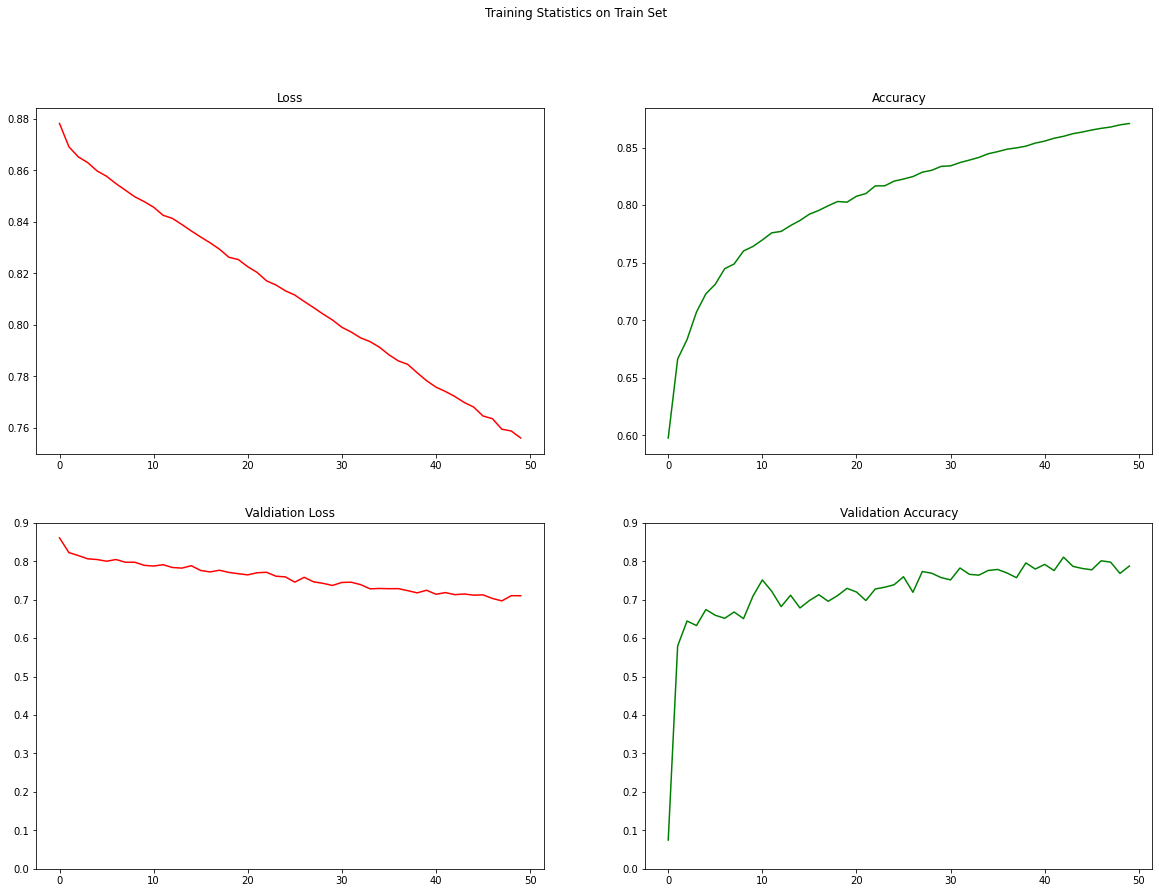

In [45]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()